<a href="https://colab.research.google.com/github/Viniciusfelp/Project_vfb2/blob/main/VFB2_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 19.3MB/s 
     |████████████████████████████████| 1.2MB 48.0MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 194kB 56.4MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 12.8MB 226kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
#Download images with Bing Image Search
key = os.environ.get('AZURE_SEARCH_KEY', 'eb4d1a91a4c649febe49767ef32d1690')

In [4]:
#This function is provided by the small utils class included with the notebooks online.
search_images_bing

<function fastbook.search_images_bing>

In [5]:
results = search_images_bing(key, 'marsupial')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
ims = ['https://www.hypeness.com.br/1/2020/05/canguru4.jpg']

In [7]:
ims[0]

'https://www.hypeness.com.br/1/2020/05/canguru4.jpg'

In [8]:
dest = gdrive/'canguru4.jpg'
download_url(ims[-1], dest)

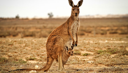

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

downloading image in separate folders

In [10]:
marsupial_types = 'canguru','coala','gamba'
path = gdrive/'marsupial'

In [11]:
if not path.exists():
    path.mkdir()
    for o in marsupial_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} marsupial')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [12]:
#checking if I have an image
fns = get_image_files(path)
fns

(#425) [Path('/content/gdrive/My Drive/marsupial/canguru/00000001.jpg'),Path('/content/gdrive/My Drive/marsupial/canguru/00000006.jpg'),Path('/content/gdrive/My Drive/marsupial/canguru/00000003.jpg'),Path('/content/gdrive/My Drive/marsupial/canguru/00000004.jpg'),Path('/content/gdrive/My Drive/marsupial/canguru/00000002.jpg'),Path('/content/gdrive/My Drive/marsupial/canguru/00000011.jpg'),Path('/content/gdrive/My Drive/marsupial/canguru/00000010.jpg'),Path('/content/gdrive/My Drive/marsupial/canguru/00000009.jpg'),Path('/content/gdrive/My Drive/marsupial/canguru/00000007.jpg'),Path('/content/gdrive/My Drive/marsupial/canguru/00000000.jpg')...]

In [13]:
#checking for corrupted file
failed = verify_images(fns)
failed

(#0) []

In [14]:
# To remove all the failed images
failed.map(Path.unlink);

In [15]:
#a DataLoaders for the dataset that I download
marsupial = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = marsupial.dataloaders(path)

In [16]:
#This command gave me a DataBlock object
dls = marsupial.dataloaders(path)

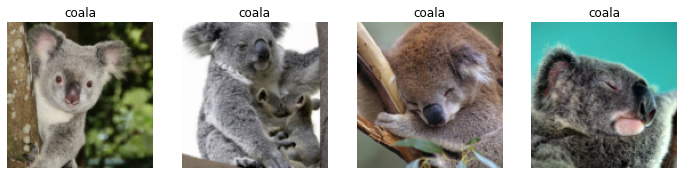

In [17]:

dls.valid.show_batch(max_n=4, nrows=1)

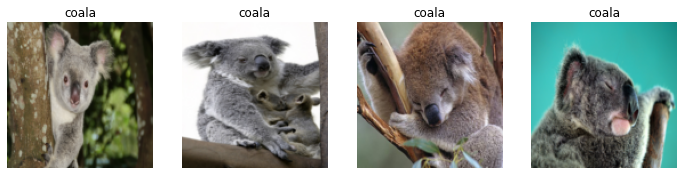

In [18]:
marsupial = marsupial.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = marsupial.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

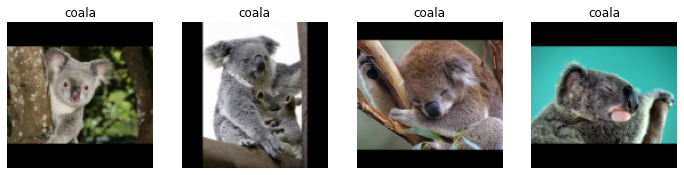

In [19]:
marsupial = marsupial.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = marsupial.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

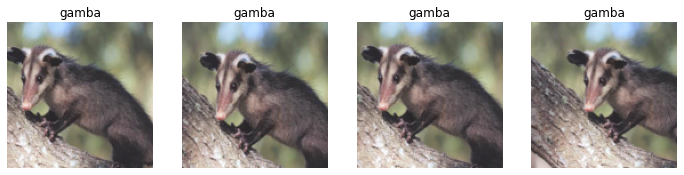

In [20]:
marsupial = marsupial.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = marsupial.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

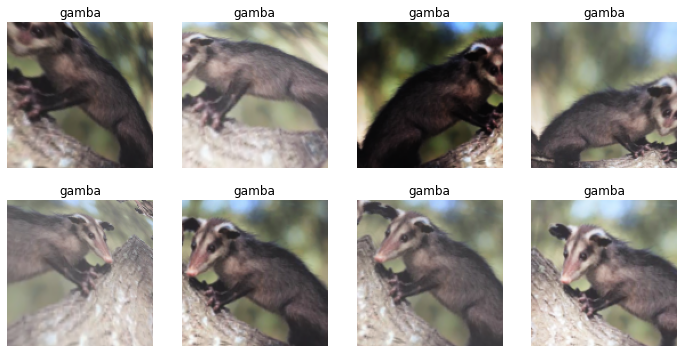

In [21]:
marsupial = marsupial.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = marsupial.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training my Model, and Using It to Clean my Data


In [22]:
marsupial = marsupial.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = marsupial.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.473034,0.433757,0.129412,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.482409,0.431914,0.117647,00:11
1,0.398969,0.408887,0.129412,00:10
2,0.314736,0.197512,0.070588,00:10
3,0.270104,0.129081,0.035294,00:11


In [24]:
#showsthe images with the highest loss in my dataset.
#interp.plot_top_losses(5, nrows=1)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

## Presizing

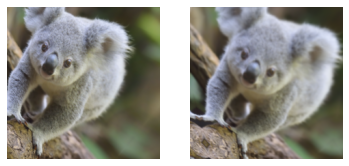

In [26]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/(path/'coala').ls()[1])]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

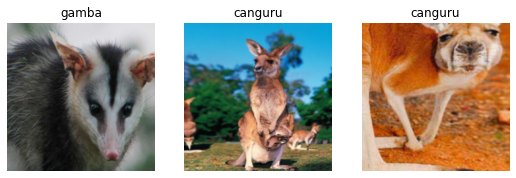

In [27]:
dls.show_batch(nrows=1, ncols=3)

In [28]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.299209,0.176864,0.082353,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.411448,0.130181,0.070588,00:11
1,0.279979,0.091601,0.058824,00:11


## ...


In [35]:
learn.export()

In [40]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [37]:
learn_inf = load_learner(path/'export.pkl')

In [41]:
learn_inf.dls.vocab

['canguru', 'coala', 'gamba']

##

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your Marsupial!'), 
      btn_upload, btn_run, out_pl, lbl_pred])